# Physics Informed Neural Network (PINN) Examples


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

In [3]:
from src.models import FCN
from src.optimization import train
from src.utils import create_gif
from src.experiment_run import Run

In [4]:
torch.manual_seed(123)

# Practical Exercise
To familiarise with the network with another example.

The size of an ionized volume $V_I=\frac{4\pi}{3} r^3_I$ around an ionizing source follows:
$$ n_H\,\frac{dV_I}{dt} = \dot{N}_\gamma - n_H^2\,C \,\alpha_B\,V_I$$

which has an exact solution:

$$ r_I(t) = r_S\left(1-e^{-t/t_{rec}}\right)$$

where the two constant term are the equilibrium radius: $r_S = \left(\frac{3 \dot{N}_\gamma}{4\pi\alpha_Bn_H^2} \right)$ and the recombination time: $t_{rec} = \frac{1}{\alpha_B n_H}$

In [5]:
import astropy.units as u
import astropy.constants as cst

In [6]:
def r_I(t):
    dotNgamma = 1e54 / u.s
    nH = 1.87e-4 / u.cm**3
    alpha_B = 2.59e-13 * u.cm**3/u.s
    C = 5

    rS = ((3*dotNgamma/(4*np.pi*alpha_B*C*nH*nH))**(1./3)).to(u.kpc)
    trec = (1./(C*alpha_B*nH)).to(u.Myr)
    print(rS, trec)
    return rS*(1-np.exp(-t/trec))**(1./3)

564.030069751601 kpc 130.85329347357774 Myr


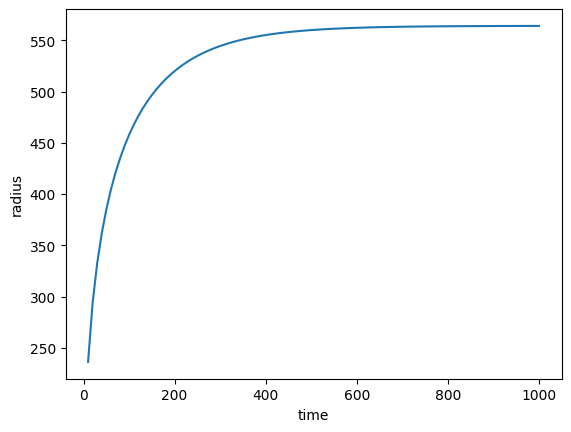

In [7]:
# define a time and calculate the exact solution
time = np.linspace(10, 1000, 100) * u.Myr
r_ion = r_I(time)

plt.plot(time.value, r_ion.value)
plt.ylabel(r'radius'), plt.xlabel('time');

In [8]:
V_ion = (4*np.pi / 3) * r_ion ** 3 / 1e9

time = torch.tensor(time.value, dtype=torch.float32).view(-1,1)
V_ion = torch.tensor(V_ion.value, dtype=torch.float32).view(-1,1)

In [9]:
def physics_loss_fn(x, y, coef=1e-54, loss_coef=1):
    dotNgamma = (1e54 / u.s).value
    nH = (1.87e-4 / u.mm**3).value
    alpha_B = (2.59e-13 * u.mm**3/u.s).value
    C = 5

    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    ode = nH * dy * coef - (dotNgamma * coef - nH ** 2 * C * alpha_B * y * coef)
    return loss_coef * torch.mean((ode * coef) ** 2)

In [10]:
model = FCN([1, 32, 1], torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

100%|██████████| 750/750 [00:10<00:00, 73.39it/s]


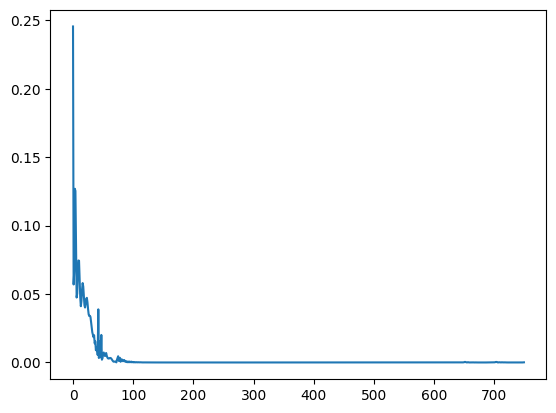

In [11]:
files = train(time, V_ion, model, optimizer, 750, save_plot=True)

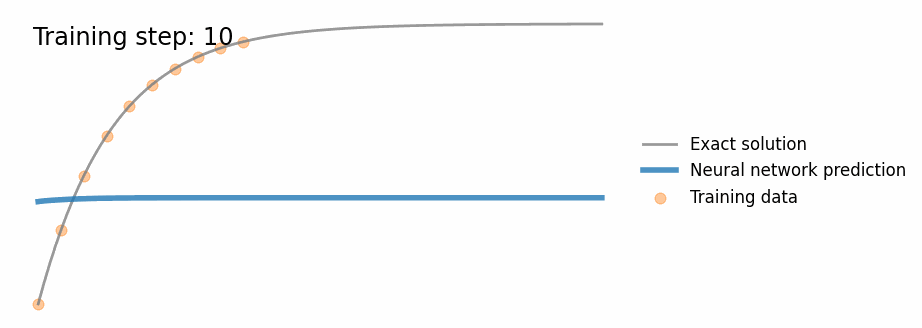

In [12]:
create_gif('img/nn.gif', files, fps=10, loop=0)

from IPython.display import Image
Image(filename='img/nn.gif')

100%|██████████| 750/750 [00:12<00:00, 60.99it/s]


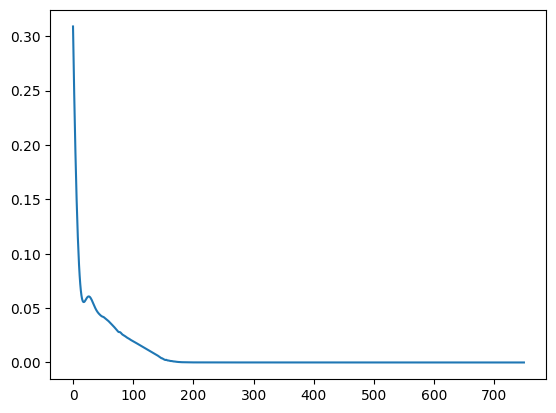

In [13]:
model = FCN([1, 32, 1], torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = train(time, V_ion, model, optimizer, 750, physics_loss_fn=physics_loss_fn, physics_loss_coef=0.01, save_plot=True)

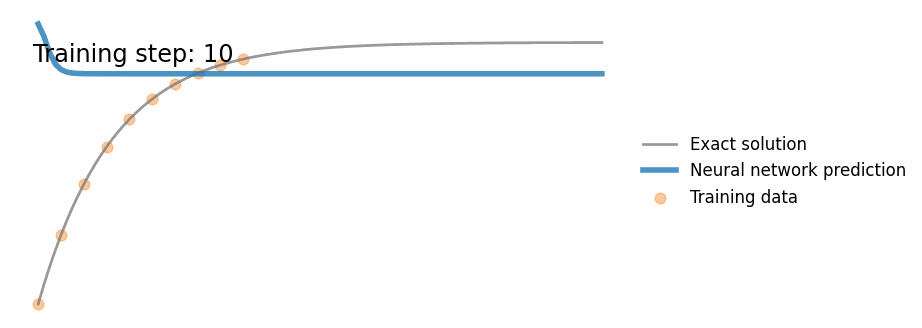

In [14]:
create_gif('img/pinn.gif', files, fps=10, loop=0)

from IPython.display import Image
Image(filename='img/pinn.gif')

In [17]:
model = FCN([1, 32, 1], torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

run = Run(time, V_ion)

run.model = model
run.optimizer = optimizer
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=0.01)

run.train(750)

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [00:10<00:00, 70.12it/s]


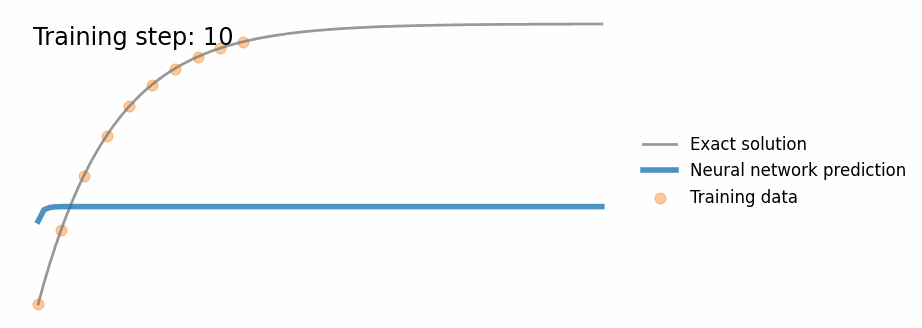

In [18]:
create_gif('img/pinn.gif', run.files, fps=10, loop=0)

from IPython.display import Image
Image(filename='img/pinn.gif')